In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split,KFold
from sklearn.pipeline import make_pipeline
from sklearn import svm, tree
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [2]:
# First we load the dataframe 
df = pickle.load(open('dataframe.pickle', 'rb'))
print(df.dtypes)
df.head()

issuercountrycode                        int64
txvariantcode                           object
bin                                    float64
amount                                 float64
currencycode                            object
shoppercountrycode                      object
shopperinteraction                      object
cardverificationcodesupplied            object
cvcresponsecode                          int64
creationdate                    datetime64[ns]
accountcode                             object
mail_id                                  int64
ip_id                                    int64
card_id                                  int64
label                                    int64
creationdate_timestamp                 float64
amount_distance                        float64
total_cards_used                         int64
dtype: object


,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,creationdate_timestamp,amount_distance,total_cards_used
0,76,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01,MexicoAccount,68370,111778,184798,1,1.435785e+09,0.0,1
1,76,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02,MexicoAccount,101299,78749,151595,1,1.435805e+09,0.0,1
2,76,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02,MexicoAccount,278604,70594,242142,1,1.435840e+09,0.0,1
3,76,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03,MexicoAccount,47409,113648,181744,1,1.435903e+09,0.0,1
4,76,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08,MexicoAccount,205501,83553,97271,1,1.436373e+09,0.0,1


In [3]:
# Why do we need to process our data with SMOTE ?
s = df.label.value_counts()
print "safe transactions: %d" % s[0]
print "fraudolent transactions: %d" % s[1]
print "Rate: %f" % (float(s[1])/float(s[0]))

safe transactions: 236353
fraudolent transactions: 345
Rate: 0.001460


In [4]:
# We filter the most interesting features
df_interesting = df[['label','ip_id','issuercountrycode','amount_distance','total_cards_used']]
df_interesting.loc[:,('issuercountrycode')] = df_interesting.loc[:,('issuercountrycode')].fillna('??') # We add a custom value for unknown codes
df_interesting.head()

/home/luigi/Desktop/my_lab/UNI/SaP_Master/UT/Q4/CDA/penv/local/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,label,ip_id,issuercountrycode,amount_distance,total_cards_used
0,1,111778,76,0.0,1
1,1,78749,76,0.0,1
2,1,70594,76,0.0,1
3,1,113648,76,0.0,1
4,1,83553,76,0.0,1


In [5]:
# Creating training and test sets
x_train, x_test, \
y_train, y_test, = train_test_split(df_interesting.drop(['label'], axis=1),
                                               df_interesting['label'],
                                               test_size = .1,
                                               random_state=12)

# Task 2

In [6]:
################  SMOTE (note, this is done after sampling) ################

# Why do we need to process our data with SMOTE ?
print "***************** Before SMOTE *******************"
safe_trans, bad_trans = y_train.value_counts()
print "safe transactions: %d" % safe_trans
print "fraudolent transactions: %d" % bad_trans
print "Rate: %f" % (float(bad_trans)/float(safe_trans))

# Apply SMOTE
sm = SMOTE(random_state=12)
x_train_smoted, y_train_smoted = sm.fit_sample(x_train, y_train)


print "***************** After SMOTE *******************"
safe_trans, bad_trans = np.bincount(y_train_smoted)
print "safe transactions: %d" % safe_trans
print "fraudolent transactions: %d" % bad_trans
print "Rate: %f" % (float(bad_trans)/float(safe_trans))


***************** Before SMOTE *******************
safe transactions: 212717
fraudolent transactions: 311
Rate: 0.001462
***************** After SMOTE *******************
safe transactions: 212717
fraudolent transactions: 212717
Rate: 1.000000


### Now let's fit some classifier on the unsmoted data

In [24]:
# Decision tree
dt = tree.DecisionTreeClassifier(max_depth=30)
dt.fit(x_train, y_train)
print dt.score(x_test,y_test)

lr = LogisticRegression()
lr.fit(x_train, y_train)
print lr.score(x_test,y_test)
    
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1e-5,
                    hidden_layer_sizes=(13, 2), random_state=1)
mlp.fit(x_train,y_train)
print mlp.score(x_test,y_test)


0.99801436417406
0.9985635825940008
0.9985635825940008


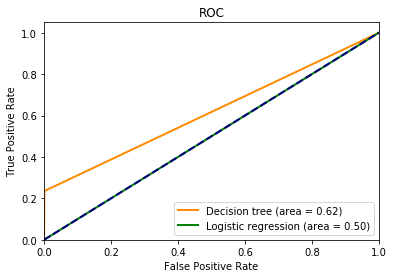

In [18]:
dt_y_predict = dt.predict(x_test)
lr_y_predict = lr.predict(x_test)


plt.figure()


fpr, tpr, thresholds = roc_curve(y_test, dt_y_predict)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Decision tree (area = %0.2f)' % roc_auc)


fpr, tpr, thresholds = roc_curve(y_test, lr_y_predict)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='green',
         lw=2, label='Logistic regression (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Now let's do the same on the smoted data, and observe the difference

In [38]:
# Decision tree
dt = tree.DecisionTreeClassifier(max_depth=30)
dt.fit(x_train_smoted, y_train_smoted)
print dt.score(x_test,y_test)

lr = LogisticRegression()
lr.fit(x_train_smoted, y_train_smoted)
print lr.score(x_test,y_test)

mlp = MLPClassifier(
                    hidden_layer_sizes=(4,5, 2), random_state=1)
mlp.fit(x_train_smoted,y_train_smoted)
print mlp.score(x_test,y_test)

0.9266582171525137
0.7378960709759189
0.9974228981833545


[0.         0.26193095 1.        ] [0.         0.61764706 1.        ] [2 1 0]
[0.         0.00114233 1.        ] [0. 0. 1.] [2 1 0]


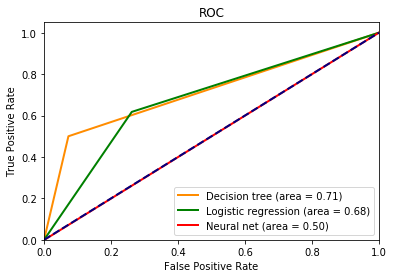

In [39]:
dt_y_predict = dt.predict(x_test)
lr_y_predict = lr.predict(x_test)
mlp_y_predict = mlp.predict(x_test)



plt.figure()


fpr, tpr, thresholds = roc_curve(y_test, dt_y_predict)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Decision tree (area = %0.2f)' % roc_auc)


fpr, tpr, thresholds = roc_curve(y_test, lr_y_predict)
roc_auc = auc(fpr,tpr)
print fpr,tpr,thresholds
plt.plot(fpr, tpr, color='green',
         lw=2, label='Logistic regression (area = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, mlp_y_predict)
print fpr,tpr,thresholds
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='red',
         lw=2, label='Neural net (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Task 3

In [ ]:
# Creating the folds
X = np.array(df_interesting.drop(['label'], axis=1))
Y = np.array(df_interesting['label'])

Folds = []

kf = KFold(n_splits=10) #Already shuffled
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    X_train, Y_train = sm.fit_sample(X_train, Y_train)
    Folds.append((X_train, Y_train, X_test, Y_test))